# Compressing the System

## Overview

### Questions

* How do I compress the system to a target density?

### Objectives

* Describe how **Variants** describe values that vary with the timestep.
* Show how to use **BoxResize** with **InverseVolumeRamp** to slowly compress the system to the target volume.
* Demonstrate the crystallization of Lennard-Jones particles.

## Boilerplate Code

In [1]:
import math

import hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

The `render` function in the next (hidden) cell will render the system state using **fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

## Procedure

`random.gsd`, generated by the previous section of this tutorial has particles randomly placed in a low density fluid state.
To find the crystalline state, you need to compress the system to a higher density.
If you were to immediately scale the system to the target density, the particle's hard cores would overlap and the integrator would become unstable.
Instead, you should gradually resize the simulation box to allow slight overlaps to relax.

## Initialize the Simulation

Configure this simulation to run on the CPU.

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='random.gsd')

Set up the molecular dynamics simulation, as discussed in the previous sections of this tutorial:

In [4]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator

## Variants

A **Variant** is a scalar-valued function of the simulation timestep that allows you change simulation parameters in a controlled manner.
The **Ramp variant** defines a function that linearly interpolates from one value to another over a given number of steps from `t_start` to `t_start + t_ramp`.

Create a **Ramp** that starts at the current step and ends 20,000 steps later:

In [5]:
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=simulation.timestep, t_ramp=20_000)

Here is what the ramp looks like as a function of timestep:

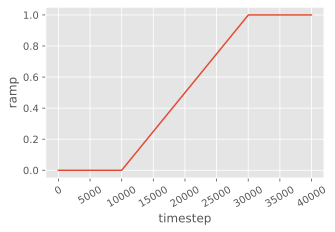

In [6]:
steps = range(0, 40000, 20)
y = [ramp(step) for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('ramp')
ax.tick_params('x', labelrotation=30)
fig

You could use a **Ramp** variant to slowly compress a system to a target **pressure** or anneal to a target **temperature**.

## Box Variants

To compress the box to a target **density**, you need to use a **BoxVariant** that defines all 6 parameters of the simulation box as a function of time.
**InverseVolumeRamp** represents a linear ramp in the box's inverse volume (or density when *N* is constant) from the initial box to the target volume between `t_start` and `t_start + t_ramp` while maintaining constant aspect ratios and tilts.

The previous tutorial placed particles at density:

In [7]:
rho = simulation.state.N_particles / simulation.state.box.volume
rho

0.3397157902913389

Compute the volume of the box at target number density `final_rho`:

In [8]:
final_rho = 1.2
final_volume = simulation.state.N_particles / final_rho

Create an **InverseVolumeRamp** that interpolates the initial simulation box to the target volume:

In [9]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)

Here is how the box length varies as function of timestep:

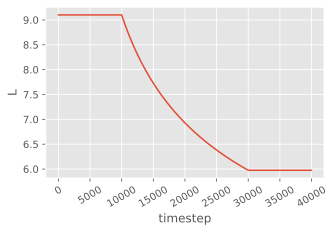

In [10]:
steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

## Gradually Resize the Simulation Box

The **BoxResize** **Updater** scales the positions of all particles and sets the simulation box following the given **BoxVariant**.

Construct a **BoxResize updater** and add it to the simulation.

In [11]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp,
)
simulation.operations.updaters.append(box_resize)

Run the simulation to compress the box.

In [12]:
simulation.run(20001)

The current density now matches the target:

In [13]:
simulation.state.N_particles / simulation.state.box.volume

1.1999999999999995

Visual inspection confirms the higher density:

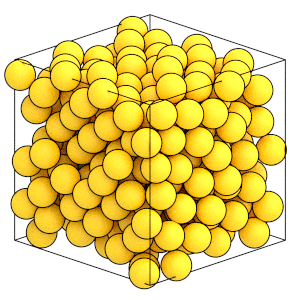

In [14]:
render(simulation.state.get_snapshot())

Now that the system has reached the target volume, remove the **BoxResize** updater from the simulation:

In [15]:
simulation.operations.updaters.remove(box_resize)

## Equilibrating the System

Run the simulation for a longer time and see if it self-assembles the ordered fcc structure:
<div class="alert alert-warning">
This cell may require several minutes to complete.
</div>

In [16]:
simulation.run(5e5)

Here is what the final state of the system looks like:

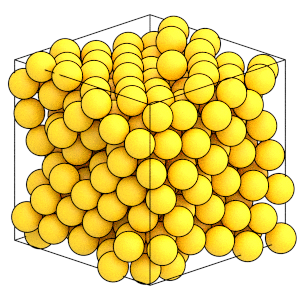

In [17]:
render(simulation.state.get_snapshot())

## Analyzing the Simulation Results

Is this the fcc structure?
Did the system reach equilibrium?
These are topics covered in the Introducing HOOMD-blue tutorial, which you can reimplement here.
You will need to save a GSD file with the simulation trajectory, then use freud's **SolidLiquid** order parameter to identify when the ordered structure appears.

This is the end of the introducing molecular dynamics tutorial!
It described molecular dynamics simulations and demonstrated how to initialize, randomize, compress, and equilibrate a system of Lennard-Jones particles.
See the other HOOMD-blue tutorials to learn about other concepts, or browse the reference documentation for more information.